In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

In [ ]:
DEVICE = 'cpu'

### Imports

In [1]:
import os
import sys
import random

In [2]:
import time
import json

In [3]:
# import warnings
# warnings.simplefilter("always")  # always show warnings!

In [4]:
import numpy as np

In [5]:
from collections import Counter

In [6]:
import torch
from torch.utils.data import Dataset

In [7]:
from torch import nn

In [8]:
from torch.nn import functional

In [9]:
import torchvision
import torchvision.transforms as transforms

In [10]:
from torchvision.transforms import InterpolationMode

In [11]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [12]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.detector import Detector, DetectorProcessorClf

In [13]:
from svetlanna.transforms import ToWavefront

In [14]:
# dataset
from src.wf_datasets import DatasetOfWavefronts

In [15]:
from tqdm import tqdm

In [16]:
from datetime import datetime

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Diffractive Autoencoder

This notebook is based on the article <span style="color:orange">"All-optical autoencoder machine learning framework using diffractive processors"</span> [[1]](https://arxiv.org/pdf/2409.20346).

In [ ]:
# list of all saved models
dir_models = 'models/autoencoder'

filepathes = []

for file in os.listdir(dir_models):
    filename = os.fsdecode(file)
    if not filename.endswith(".pth"):
        filepathes.append(filename)

print(*sorted(filepathes), sep='\n')

.DS_Store
ae_no_phases
ae_slm_encoder
ae_with_phases


In [19]:
RESULTS_FOLDER = f'{dir_models}/ae_no_phases'  # SELECTING AN EXPERIMENT
RESULTS_FOLDER

'models/autoencoder/ae_no_phases'

In [20]:
# read conditions from file:
with open(f'{RESULTS_FOLDER}/conditions.json') as json_file:
    VARIABLES = json.load(json_file)

VARIABLES

{'data_path': './data',
 'results_path': 'models/autoencoder/ae_exp_26-03-2025_16-27',
 'wavelength': 0.000435,
 'neuron_size': 0.000435,
 'mesh_size': [160, 160],
 'use_apertures': False,
 'aperture_size': [64, 64],
 'resize': [64, 64],
 'modulation': 'amp',
 'max_phase': 6.283185307179586,
 'free_space_method': 'AS',
 'distance': 0.0348,
 'encoder_use_slm': False,
 'encoder_num_layers': 4,
 'encoder_init_phases': 3.141592653589793,
 'encoder_slm_shapes': [160, 160],
 'encoder_slm_levels': 256,
 'encoder_slm_step_funcs': 'linear',
 'preserve_phase': False,
 'decoder_use_slm': False,
 'decoder_num_layers': 4,
 'decoder_init_phases': 3.141592653589793,
 'decoder_slm_shapes': [160, 160],
 'decoder_slm_levels': 256,
 'decoder_slm_step_funcs': 'linear',
 'eta_th': 0.04,
 'encoding_region_size': [20, 20],
 'gamma_rec': 1000.0,
 'gamma_en': 2e-05,
 'gamma_eff': 0.1,
 'DEVICE': 'cpu',
 'train_batch_size': 128,
 'val_batch_size': 128,
 'adam_lr': 0.01,
 'number_of_epochs': 50}

In [21]:
# functions for SLM step (look documentation of SLM)
SLM_STEPS = {
    'linear': lambda x: x,
}

# 1. Simulation parameters

Citations from **Methods and Materials** (_Parameter details of diffractive processors_) of [[1]](https://arxiv.org/pdf/2409.20346):

> ...  i.e., $\lambda = 0.435$ mm for $f_0 = 0.69$ THz ...

> The diffractive layer sets of numerical models were all $69.6$ mm $\times$ $69.6$ mm in size ($160 \times 160$ pixels)

In [22]:
working_wavelength = VARIABLES['wavelength']  # [m] - like for MNIST

c_const = 299_792_458  # [m / s]
working_frequency = c_const / working_wavelength # [Hz]

In [23]:
print(f'lambda    = {working_wavelength * 1e3:.3f} mm')
print(f'frequency = {working_frequency / 1e12:.3f} THz')

lambda    = 0.435 mm
frequency = 0.689 THz


In [24]:
# neuron size (square)
neuron_size = VARIABLES['neuron_size']  # [m] - like for MNIST
print(f'neuron size = {neuron_size * 1e3:.3f} mm')

neuron size = 0.435 mm


In [25]:
APERTURES = VARIABLES['use_apertures']  # add apertures BEFORE each diffractive layer or not

In [26]:
LAYER_SIZE = VARIABLES['mesh_size']  # mesh size
DETECTOR_SIZE = VARIABLES['aperture_size']

In [27]:
# number of neurons in simulation
x_layer_nodes = LAYER_SIZE[1]
y_layer_nodes = LAYER_SIZE[0]
# Comment: Same size as proposed!

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (in neurons): 160 x 160 = 25600


In [28]:
# physical size of each layer
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in mm): {x_layer_size_m * 1e3 :.3f} x {y_layer_size_m * 1e3 :.3f}')

Layer size (in mm): 69.600 x 69.600


In [29]:
X_LAYER_SIZE_M = x_layer_size_m
Y_LAYER_SIZE_M = y_layer_size_m

In [30]:
# simulation parameters for the rest of the notebook

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Dataset preparation

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [31]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = VARIABLES['data_path']  # folder to store data

### 2.1.1. Load Train and Test datasets of images

In [32]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=True,
)

In [33]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=True,
)

In [34]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Create Train and Test datasets of wavefronts

From [[1]](https://arxiv.org/pdf/2409.20346):

> $FOV_I$ and $FOV_{II}$ were both $27.84$ mm $\times$ $27.84$ mm in size ($64\times64$ pixels)

In [35]:
# select modulation type
MODULATION_TYPE = VARIABLES['modulation']  # using ONLY amplitude to encode each picture in a Wavefront!
RESIZE_SHAPE = VARIABLES['resize']  # size to resize pictures to add 0th padding then (up to the mesh size)

In [36]:
resize_y = RESIZE_SHAPE[0]
resize_x = RESIZE_SHAPE[1]  # shape for transforms.Resize

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [ ]:
# compose all transforms!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- selected modulation type here!!!
  ]
)

In [38]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

In [39]:
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

In [40]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


# 3. Autoencoder

> distances between two successive layers, $d_l$, were all $34.8$ mm ($80\lambda$)

> model consists of five equally spaced phase-only modulation diffractive layers ($N=5$)

In [41]:
if 'preserve_phase' not in VARIABLES.keys():
    PRESERVE_PHASE = False
else:
    PRESERVE_PHASE = VARIABLES['preserve_phase']

In [42]:
NUM_ENCODER_LAYERS = VARIABLES['encoder_num_layers']  # number of diffractive layers
NUM_DECODER_LAYERS = VARIABLES['decoder_num_layers']  # number of diffractive layers

ENCODER_USE_SLM = VARIABLES['encoder_use_slm']  # if we use SLM or DiffractiveLayer as a main element for encoder/decoder
DECODER_USE_SLM = VARIABLES['decoder_use_slm']

MAX_PHASE = VARIABLES['max_phase']

FS_METHOD = VARIABLES['free_space_method']
FS_DISTANCE = VARIABLES['distance']  # [m] - distance between difractive layers

In [ ]:
if isinstance(VARIABLES['encoder_init_phases'], list):
    ENCODER_INIT_PHASES = VARIABLES['encoder_init_phases']
else:
    ENCODER_INIT_PHASES = [VARIABLES['encoder_init_phases'] for _ in range(NUM_ENCODER_LAYERS)]

if isinstance(VARIABLES['decoder_init_phases'], list):
    DECODER_INIT_PHASES = VARIABLES['decoder_init_phases']
else:
    DECODER_INIT_PHASES = [VARIABLES['decoder_init_phases'] for _ in range(NUM_DECODER_LAYERS)]

assert len(ENCODER_INIT_PHASES) == NUM_ENCODER_LAYERS
assert len(DECODER_INIT_PHASES) == NUM_DECODER_LAYERS

#### SLM settings if needed (for encoder/decoder)

In [ ]:
if ENCODER_USE_SLM:
    ENCODER_SLM_VARIABLES = {}

    for key in ['encoder_slm_shapes', 'encoder_slm_levels', 'encoder_slm_step_funcs']:
        if key != 'encoder_slm_step_funcs':

            if isinstance(VARIABLES[key], list):
                ENCODER_SLM_VARIABLES[key] = VARIABLES[key]
            else:  # all SLM's have the same parameter
                ENCODER_SLM_VARIABLES[key] = [VARIABLES[key] for _ in range(NUM_ENCODER_LAYERS)]

        else:  # for step functions!

            if isinstance(VARIABLES[key], list):
                ENCODER_SLM_VARIABLES[key] = [SLM_STEPS[name] for name in VARIABLES[key]]
            else:  # all SLM's have the same parameter
                ENCODER_SLM_VARIABLES[key] = [SLM_STEPS[VARIABLES[key]] for _ in range(NUM_ENCODER_LAYERS)]

        assert len(ENCODER_SLM_VARIABLES[key]) == NUM_ENCODER_LAYERS

In [ ]:
if DECODER_USE_SLM:
    DECODER_SLM_VARIABLES = {}

    for key in ['decoder_slm_shapes', 'decoder_slm_levels', 'decoder_slm_step_funcs']:
        if key != 'decoder_slm_step_funcs':

            if isinstance(VARIABLES[key], list):
                DECODER_SLM_VARIABLES[key] = VARIABLES[key]
            else:  # all SLM's have the same parameter
                DECODER_SLM_VARIABLES[key] = [VARIABLES[key] for _ in range(NUM_DECODER_LAYERS)]

        else:  # for step functions!

            if isinstance(VARIABLES[key], list):
                DECODER_SLM_VARIABLES[key] = [SLM_STEPS[name] for name in VARIABLES[key]]
            else:  # all SLM's have the same parameter
                DECODER_SLM_VARIABLES[key] = [SLM_STEPS[VARIABLES[key]] for _ in range(NUM_DECODER_LAYERS)]

        assert len(DECODER_SLM_VARIABLES[key]) == NUM_DECODER_LAYERS

## 3.1. Architecture

### 3.1.1. Functions to get new elements

In [ ]:
# functions that return single elements for further architecture

def get_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Returns FreeSpace layer with a bounded distance parameter.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_const_phase_layer(
    sim_params: SimulationParameters,
    value, max_phase=2 * torch.pi
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value

    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
    )  # ATTENTION TO DOCUMENTATION!


# CHANGE ACCORDING TO THE DOCUMENTATION OF SLM!
def get_const_slm_layer(
    sim_params: SimulationParameters,
    mask_shape,
    phase_value,
    num_levels,
    step_func,
    height_m=Y_LAYER_SIZE_M,
    width_m=X_LAYER_SIZE_M,
    max_phase=2 * torch.pi
):
    """
    Returns SpatialLightModulator with a constant phase mask.
    """
    y_nodes, x_nodes = mask_shape
    const_mask = torch.ones(size=(y_nodes, x_nodes)) * phase_value

    return elements.SpatialLightModulator(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
        height=height_m,
        width=width_m,
        # location=(0., 0.),  # by default
        number_of_levels=num_levels,
        step_function=step_func,
        # mode='nearest',  # by default it is 'nearest'
    )  # ATTENTION TO DOCUMENTATION!

### 3.1.2. Список элементов  
Функция для получения списка элементов для воспроизведения архитектуры:

In [ ]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_distance,
    freespace_method,
    apertures=False,
    aperture_size=(100, 100),
    mode='encoder'
):
    """
    Composes a list of elements for an encoder (with no Detector).
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_distance : float,
        A distance between phase layers in [m].
    freespace_method : str
        Propagation method for free spaces in a setup.

    apertures : bool
        If True, than before each DiffractiveLayer (and detector) we add a square aperture.
        Comment: there are strickt square apertures!
    aperture_size : tuple
        A size of square apertures.

    mode : str
        Takes values: 'encoder' or 'decoder'.

    Returns
    -------
    elements_list : list(Element)
        List of Elements for an encoder/decoder.
    """
    elements_list = []  # list of elements

    if mode == 'encoder':
        use_slm = ENCODER_USE_SLM
        init_phases = ENCODER_INIT_PHASES
        if use_slm:
            slm_masks_shape = ENCODER_SLM_VARIABLES['encoder_slm_shapes']
            slm_levels = ENCODER_SLM_VARIABLES['encoder_slm_levels']
            slm_funcs = ENCODER_SLM_VARIABLES['encoder_slm_step_funcs']

    if mode == 'decoder':
        use_slm = DECODER_USE_SLM
        init_phases = DECODER_INIT_PHASES
        if use_slm:
            slm_masks_shape = DECODER_SLM_VARIABLES['decoder_slm_shapes']
            slm_levels = DECODER_SLM_VARIABLES['decoder_slm_levels']
            slm_funcs = DECODER_SLM_VARIABLES['decoder_slm_step_funcs']

    if apertures:  # equal masks for all apertures (select a part in the middle)
        aperture_mask = torch.ones(size=aperture_size)

        y_nodes, x_nodes = simulation_parameters.axes_size(axs=('H', 'W'))
        y_mask, x_mask = aperture_mask.size()
        pad_top = int((y_nodes - y_mask) / 2)
        pad_bottom = y_nodes - pad_top - y_mask
        pad_left = int((x_nodes - x_mask) / 2)
        pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad

        # padding transform to match aperture size with simulation parameters
        aperture_mask = functional.pad(
            input=aperture_mask,
            pad=(pad_left, pad_right, pad_top, pad_bottom),
            mode='constant',
            value=0
        )

    # first FreeSpace layer before first DiffractiveLayer
    elements_list.append(
        get_free_space(
            simulation_parameters,  # simulation parameters for the notebook
            freespace_distance,  # in [m]
            freespace_method=freespace_method,
        )
    )

    # compose the architecture
    for ind_layer in range(num_layers):

        # add strickt square Aperture
        if apertures:
            elements_list.append(
                elements.Aperture(
                    simulation_parameters=simulation_parameters,
                    mask=aperture_mask
                )
            )

        # ------------------------------------------------------------PHASE LAYER
        if use_slm:  # add a phase layer (SLM or DiffractiveLayer)
            # add SLM (learnable phase mask)
            elements_list.append(
                get_const_slm_layer(
                    simulation_parameters,
                    mask_shape=slm_masks_shape[ind_layer],
                    phase_value=init_phases[ind_layer],
                    num_levels=slm_levels[ind_layer],
                    step_func=slm_funcs[ind_layer],
                    max_phase=MAX_PHASE
                )
            )
        else:
            # add DiffractiveLayer (learnable phase mask)
            elements_list.append(
                get_const_phase_layer(
                    simulation_parameters,
                    value=init_phases[ind_layer],
                    max_phase=MAX_PHASE
                )
            )
        # -----------------------------------------------------------------------

        # add FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                freespace_distance,  # in [m]
                freespace_method=freespace_method,
            )
        )

    return elements_list

### 3.1.3. Класс автокодировщика (двунаправленного энкодера-декодера)

In [ ]:
class AutoencoderSymmetrical(nn.Module):
    """
    An autoencoder:
        .encode() - forward propagation through encoder elements
        .decode() - forward propagation through decoder elements
    """

    def __init__(
        self,
        sim_params: SimulationParameters,
        encoder_num_layers: int,
        decoder_num_layers: int,
        fs_distance: float,
        fs_method: str = 'AS',
        encoder_elements_list: list = None,
        decoder_elements_list: list = None,
        device: str | torch.device = torch.get_default_device(),
    ):
        """
        Parameters
        ----------
        sim_params : SimulationParameters
            Simulation parameters for the task.
        encoder_num_layers, decoder_num_layers : int
            Number of layers in encoder/decoder.
        fs_distance : float,
            A distance between phase layers in [m].
        fs_method : str
            Propagation method for free spaces in a setup.
        elements_list : list
            List of elements to compose an autoencoder.
        """
        super().__init__()

        self.sim_params = sim_params

        self.h, self.w = self.sim_params.axes_size(
            axs=('H', 'W')
        )  # height and width for a wavefronts

        self.__device = device
        self.fs_method = fs_method

        # ENCODER
        if encoder_elements_list is None:
            encoder_elements_list = get_elements_list(
                encoder_num_layers,
                self.sim_params,
                fs_distance,
                fs_method,
                apertures=VARIABLES['use_apertures'],
                aperture_size=VARIABLES['aperture_size'],
                mode='encoder'
            )  # no Detector here!

        # self.encoder_elements = encoder_elements_list
        self.encoder = nn.Sequential(*encoder_elements_list).to(self.__device)

        # DECODER
        if decoder_elements_list is None:
            decoder_elements_list = get_elements_list(
                decoder_num_layers,
                self.sim_params,
                fs_distance,
                fs_method,
                apertures=VARIABLES['use_apertures'],
                aperture_size=VARIABLES['aperture_size'],
                mode='decoder',  # DECODER is a mirror image of ENCODER!
            )  # no Detector here!

        # self.decoder_elements = decoder_elements_list
        self.decoder = nn.Sequential(*decoder_elements_list).to(self.__device)

    def encode(self, wavefront_in):
        """
        Forward propagation through the autoencoder - encode an image wavefront (input).

        Returns
        -------
        wavefront_encoded : Wavefront
            An encoded input wavefront.
        """
        return self.encoder(wavefront_in)

    def decode(self, wavefront_encoded):
        """
        Backward propagation through the autoencoder - decode an wncoded image.

        Returns
        -------
        wavefront_decoded : Wavefront
            A decoded wavefront.
        """
        return self.decoder(wavefront_encoded)

    def stepwise_propagation(self, input_wavefront: Wavefront, mode: str='encode'):
        """
        Функция, которая последовательно применяет метод `forward` каждого элемента
        энкодера или декодера к входному волновому фронту.

        Параметры
        ----------
        input_wavefront : torch.Tensor
            Волновой фронт, поступающий на вход оптической сети.

        mode : str
            Режим работы: 'encode' (кодирование) или 'decode' (декодирование).

        Возвращает
        -------
        str
            Строка, представляющая схему распространения через систему.

        list(torch.Tensor)
            Список, показывающий эволюцию волнового фронта
            при прохождении через систему.
        """
        this_wavefront = input_wavefront
        # список волновых фронтов во время распространения начального волнового фронта через систему.
        steps_wavefront = [this_wavefront]
        optical_scheme = ''

        if mode == 'encode':
            net = self.encoder
        if mode == 'decode':
            net = self.decoder

        net.eval()
        for ind_element, element in enumerate(net):
            # for visualization in a console
            element_name = type(element).__name__
            optical_scheme += f'-({ind_element})-> [{ind_element + 1}. {element_name}] '

            if ind_element == len(net) - 1:
                optical_scheme += f'-({ind_element + 1})->'

            # element forward
            with torch.no_grad():
                this_wavefront = element.forward(this_wavefront)

            steps_wavefront.append(this_wavefront)  # add a wavefront to list of steps

        return optical_scheme, steps_wavefront

    def forward(self, wavefront_in):
        """
        Параметры
        ----------
        wavefront_in: Wavefront('bs', 'H', 'W')
            Входной волновой фронт с размерностью: размер батча, высота, ширина.

        Возвращает
        -------
        amplitudes_encoded, amplitudes_decoded : torch.Tensor
            Амплитуды закодированных и декодированных волновых фронтов.
        """
        if len(wavefront_in.shape) > 2:  # if a batch is an input
            batch_flag = True
            bs = wavefront_in.shape[0]
        else:
            batch_flag = False

        # encode
        wavefront_encoded = self.encode(wavefront_in)
        # decode from intencity!
        if PRESERVE_PHASE:
            wavefront_decoded = self.decode(wavefront_encoded)
        else:
            wavefront_encoded_no_phase = wavefront_encoded.abs() + 0j
            wavefront_decoded = self.decode(wavefront_encoded_no_phase)

        # results to calculate loss
        amplitudes_encoded = wavefront_encoded.abs()
        amplitudes_decoded = wavefront_decoded.abs()

        return amplitudes_encoded, amplitudes_decoded

## 3.2. Необученный энкодер


In [49]:
def get_autoencoder():
    return AutoencoderSymmetrical(
        sim_params=SIM_PARAMS,
        encoder_num_layers=NUM_ENCODER_LAYERS,
        decoder_num_layers=NUM_DECODER_LAYERS,
        fs_distance=FS_DISTANCE,
        fs_method=FS_METHOD,
    )

# 4. Загрузка и тестирование модели

In [ ]:
DEVICE = VARIABLES['DEVICE']

In [51]:
if DEVICE == 'cuda':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

'cpu'

## 4.1. Подготовка к тестированию

### 4.1.1. `DataLoader`'ы

Цитата из статьи [[1]](https://arxiv.org/pdf/2409.20346):

> Во время каждой итерации обучения в модель подавался мини-батч, состоящий из $128$ случайно выбранных изображений.



In [ ]:
train_bs = VARIABLES['train_batch_size']
val_bs = VARIABLES['val_batch_size']

In [53]:
train_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_train_ds,
    batch_size=train_bs,
    shuffle=True,
    drop_last=False,
)

test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=val_bs,
    shuffle=True,
    drop_last=False,
)

### 4.1.2. Оптимизатор и функция потерь

Цитаты из раздела "Методы" статьи [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> Для всех трёх архитектур скорость обучения была установлена на уровне $0{,}01$, размер обучающего батча — $20$ для D-RNN.

> Мы применяем алгоритм стохастического градиентного спуска, а именно — оптимизатор Adam (адаптивная оценка моментов) ...

In [54]:
LR = VARIABLES['adam_lr']

In [55]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

#### Функция потерь  
Из статьи [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> $$
\mathcal{L}_\text{OAE} = \mathcal{L}_\text{Rec}+\gamma_{En} \mathcal{L}_{En} +\gamma_{eff}\mathcal{L}_{eff}
$$

Здесь $\mathcal{L}_\text{Rec}$ — ошибка реконструкции между входными изображениями и соответствующими декодированными изображениями:

> $$
\mathcal{L}_\text{Rec} = \mathcal{L}_\text{MSE} \left( I(x,y), O_{De}(x,y) \right)
= E \left[ \left| \sigma_1 I(x,y) - \sigma_2 O_{De}(x,y) \right|^2 \right]
$$

> $$
\sigma_1 = \frac{1}{\sum\limits_{(x,y)} I(x,y)}, \quad
\sigma_2 = \sigma_1 \cdot \frac{\sum\limits_{(x,y)} I(x,y) O_{De}(x,y)}{\sum\limits_{(x,y)} |O_{De}(x,y)|^2}
$$

где $E[\cdot]$ — оператор усреднения, $I(x,y)$ — входное изображение, $O_{De}(x,y)$ — декодированное изображение. Параметры $\sigma_1$ и $\sigma_2$ компенсируют потерю энергии из-за дифракции.

---

$\mathcal{L}_{En}$ — регуляризационный член, максимизирующий концентрацию энергии в целевой области кодирования:

> $$
\mathcal{L}_{En} = 
-\ln\left( 
\frac{\sum\limits_{(x,y)} |M(x,y)O_{En}(x,y)|^2 }{\sum\limits_{(x,y)} |O_{En}(x,y)|^2 }
\right)
$$

> $$
M(x,y) =
\begin{cases}
1,\;(x,y) \in \text{области кодирования} \\\\
0,\; \text{вне области}
\end{cases}
$$

где $O_{En}(x,y)$ — выход энкодера. Маска $M(x,y)$ задаёт желаемую форму выходного распределения, аналогично априорному распределению в VAE.

---

$\mathcal{L}_{Eff}$ — регуляризация, контролирующая эффективность двунаправленной дифракции:

> $$
\mathcal{L}_{Eff} = 
\begin{cases}
-\ln \left( \frac{\eta_R}{\eta_{Th}} \right), & \eta_R < \eta_{Th} \\\\
0, & \eta_R \geq \eta_{Th}
\end{cases}
$$

> $$
\eta_R = \frac{ \sum\limits_{(x,y)} |O_{De}(x,y)|^2 }{ \sum\limits_{(x,y)} |I(x,y)|^2 }
$$

где $\eta_R$ — наблюдаемая эффективность реконструкции, $\eta_{Th}$ — заданный порог.

>... при $\eta_{Th}$ в уравнении, равном $4%$

In [56]:
ETA_TH = VARIABLES['eta_th']

> The encoding region of tiny SOAE and MOAE models are both a square with a side length of $8$, resulting
in a compression ratio of $16$.

In [57]:
REGION_MASK_SIZE = VARIABLES['encoding_region_size']

In [ ]:
REGION_MASK = torch.ones(size=REGION_MASK_SIZE)  # M(x,y)

y_nodes, x_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))
y_mask, x_mask = REGION_MASK_SIZE
pad_top = int((y_nodes - y_mask) / 2)
pad_bottom = y_nodes - pad_top - y_mask
pad_left = int((x_nodes - x_mask) / 2)
pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad

# padding transform to match aperture size with simulation parameters
REGION_MASK = functional.pad(
    input=REGION_MASK,
    pad=(pad_left, pad_right, pad_top, pad_bottom),
    mode='constant',
    value=0
)

print(f'M(x,y) shape: ({REGION_MASK.shape[0]}, {REGION_MASK.shape[1]})')
print(f'Number of nonzero (ones) elements: {int(REGION_MASK.sum().item())}')

M(x,y) shape: (160, 160)
Number of nonzero (ones) elements: 400


In [59]:
GAMMA_EN = VARIABLES['gamma_en']
GAMMA_EFF = VARIABLES['gamma_eff']

In [ ]:
if 'gamma_rec' in VARIABLES.keys():
    GAMMA_REC = VARIABLES['gamma_rec']

else:
    GAMMA_REC = 1.0

#### Функция

In [ ]:
def CustomLossFunc(input_image, encoded_image_amp, decoded_image_amp):
    """
    Вычисляет функцию ошибки, как использовалось в статье [1].

    Параметры:
    -----------
    input_image : Wavefront
        Входной волновой фронт, построенный из изображения (или батча изображений).

    encoded_image_amp : Wavefront (~torch.Tensor)
        Результат кодирования (прямого распространения через автокодировщик) входного изображения — амплитуды.

    decoded_image_amp : Wavefront (~torch.Tensor)
        Результат декодирования (обратного распространения через автокодировщик) закодированного изображения — амплитуды.

    Комментарий: первая размерность отвечает за размер батча!
    """
    if len(input_image.shape) > 2:  # if a batch is an input
        batch_flag = True
        bs = input_image.shape[0]
    else:
        batch_flag = False

    h, w = SIM_PARAMS.axes_size(axs=('H', 'W'))
    number_of_layer_neurons = h * w
    input_image_amp = input_image.abs()

    # the reconstruction error - L_Rec
    sigma_1 = 1 / (input_image_amp.sum(dim=(-2, -1)))
    sigma_2 = sigma_1 * (
        (input_image_amp * decoded_image_amp).sum(dim=(-2, -1)) /
        (decoded_image_amp ** 2).sum(dim=(-2, -1))
    )

    if batch_flag:
        sigma_1 = sigma_1.view(-1, 1, 1)
        sigma_2 = sigma_2.view(-1, 1, 1)

    l_rec = (
        (
            (
                sigma_1 * input_image_amp -
                sigma_2 * decoded_image_amp
            ) ** 2
        ).sum(dim=(-2, -1)) / number_of_layer_neurons
    )

    # regularization term - L_En
    l_en = -torch.log(
        ((REGION_MASK * encoded_image_amp) ** 2).sum(dim=(-2, -1)) /
        (encoded_image_amp ** 2).sum(dim=(-2, -1))
    )

    eta_r = (
        (decoded_image_amp ** 2).sum(dim=(-2, -1)) /
        (input_image_amp ** 2).sum(dim=(-2, -1))
    )
    if batch_flag:
        l_eff = torch.where(eta_r < ETA_TH, -torch.log(eta_r / ETA_TH), 0.0)
    else:
        l_eff = -torch.log(eta_r / ETA_TH) if eta_r < ETA_TH else 0.0

    # Вычисление потерь
    loss = GAMMA_REC * l_rec + GAMMA_EN * l_en + GAMMA_EFF * l_eff

    return (l_rec.mean(), l_en.mean(), l_eff.mean()), loss.mean()

#### Объект

In [62]:
loss_func = CustomLossFunc
loss_func_name = 'custom loss'

### 4.1.3. Циклы обучения и оценки производительности модели

In [ ]:
def autoencoder_train(
    autoencoder, wavefronts_dataloader,
    loss_func, optimizer,
    device='cpu', show_process=False
):
    """
    Функция для обучения `AutoencoderBidirectional`
    ...

    Параметры
    ----------
        autoencoder : torch.nn.Module
            Автокодировщик, который является энкодером в одном направлении и декодером — в другом.

        wavefronts_dataloader : torch.utils.data.DataLoader
            Загрузчик (по батчам) обучающего датасета волновых фронтов.

        loss_func :
            Функция потерь для такого автокодировщика.

        optimizer : torch.optim
            Оптимизатор для обучения.

        device : str
            Устройство, на котором выполняются вычисления.

        show_process : bool
            Флаг для отображения (или скрытия) индикатора прогресса.

    Возвращает
    ----------
        batches_loss_parts : list[list]
            Части пользовательской функции потерь для каждого батча.

        batches_losses : list[float]
            Потери для каждого батча за эпоху.
    """
    autoencoder.train()  # activate 'train' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_loss_parts = []  # to store accuracy for each batch

    correct_preds = 0
    size = 0
    ind_batch = 1

    for batch_wavefronts, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='train', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        # batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        # forward of an autoencoder
        encoded_image_amp, decoded_image_amp = autoencoder(batch_wavefronts)

        loss_parts, loss = loss_func(batch_wavefronts, encoded_image_amp, decoded_image_amp)

        loss.backward()
        optimizer.step()

        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        batches_loss_parts.append([part.item() for part in loss_parts])

    return batches_loss_parts, batches_losses

In [ ]:
def autoencoder_validate(
    autoencoder, wavefronts_dataloader,
    loss_func,
    device='cpu', show_process=False
    ):
    """
    Функция для валидации `AutoencoderBidirectional`
    ...

    Параметры
    ----------
        autoencoder : torch.nn.Module
            Автокодировщик, который выступает энкодером в одном направлении и декодером — в другом.

        wavefronts_dataloader : torch.utils.data.DataLoader
            Загрузчик (по батчам) обучающего датасета волновых фронтов.

        loss_func :
            Функция потерь для такого автокодировщика.

        device : str
            Устройство, на котором будет производиться вычисление.

        show_process : bool
            Флаг для отображения (или скрытия) индикатора прогресса.

    Возвращает
    ----------
        batches_loss_parts : list[list]
            Части пользовательской функции потерь для каждого батча.

        batches_losses : list[float]
            Потери для каждого батча за эпоху.
    """
    autoencoder.eval()
    batches_losses = []  # для сохранения потерь для каждого батча
    batches_loss_parts = []  # для сохранения точности для каждого батча
    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        # batch_labels = batch_labels.to(device)

        with torch.no_grad():
            encoded_image_amp, decoded_image_amp = autoencoder(batch_wavefronts)
            loss_parts, loss = loss_func(batch_wavefronts, encoded_image_amp, decoded_image_amp)

        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        batches_loss_parts.append([part.item() for part in loss_parts])

    return batches_loss_parts, batches_losses

## 4.2. Загрузка модели

In [65]:
# Путь к файлу с сохраненной моделью
load_model_filepath = f'{RESULTS_FOLDER}/autoencoder_net.pth'

loaded_autoencoder = get_autoencoder()
loaded_autoencoder.load_state_dict(torch.load(load_model_filepath))

/Users/giyuu/science-phd/git-projects/SVETlANNa/svetlanna/elements/free_space.py:152: UserWarning: Aliasing problems may occur in the AS method. Consider reducing the distance or increasing the Nx*dx product.
  warn(
/Users/giyuu/science-phd/git-projects/SVETlANNa/svetlanna/elements/free_space.py:158: UserWarning: Aliasing problems may occur in the AS method. Consider reducing the distance or increasing the Ny*dy product.
  warn(
/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_51437/3423860407.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed duri

<All keys matched successfully>

In [66]:
loss_func_power = 5

In [ ]:
# Проверка тестовых метрик
test_loss_parts_0, test_losses_0 = autoencoder_validate(
    loaded_autoencoder,
    test_wf_loader,  # Dataloader для обучающей выборки
    loss_func,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results of the trained autoencoder on TEST set:\n' +
    f'\t{loss_func_name} : {np.mean(test_losses_0) * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}'
)

# LOSS PARTS
l_rec_0, l_en_0, l_eff_0 = np.mean(test_loss_parts_0, axis=0)
print(f'\t\tg_rec * L_rec = {GAMMA_REC * l_rec_0 * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}')
print(f'\t\tg_en * L_en = {GAMMA_EN * l_en_0 * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}')
print(f'\t\tg_eff * L_eff = {GAMMA_EFF * l_eff_0 * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}')

validation: 100%|████████████████████████████████████████████| 79/79 [00:25<00:00,  3.08it/s]

Results of the trained autoencoder on TEST set:
	custom loss : 3.035625 * 1e-5
		g_rec * L_rec = 2.608273 * 1e-5
		g_en * L_en = 0.427353 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5


## 4.3. Загрузка результатов

In [68]:
losses_data = np.genfromtxt(
    f'{RESULTS_FOLDER}/training_curves.csv',
    delimiter=','
)

In [69]:
losses_parts_names = ['l_rec', 'l_en', 'l_eff']

In [ ]:
n_epochs = VARIABLES['number_of_epochs']

train_epochs_loss_parts = {}
val_epochs_loss_parts = {}

(
    train_epochs_loss_parts['l_rec'], train_epochs_loss_parts['l_en'], train_epochs_loss_parts['l_eff'], train_epochs_losses,
    val_epochs_loss_parts['l_rec'], val_epochs_loss_parts['l_en'], val_epochs_loss_parts['l_eff'], val_epochs_losses
) = losses_data[1:, :].T

#### Кривые обучения

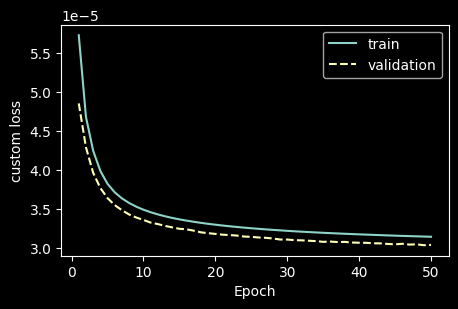

In [71]:
# learning curve
fig, ax0 = plt.subplots(1, 1, figsize=(5, 3))

ax0.plot(range(1, n_epochs + 1), np.array(train_epochs_losses), label='train')
ax0.plot(range(1, n_epochs + 1), np.array(val_epochs_losses), linestyle='dashed', label='validation')

ax0.set_ylabel(loss_func_name)
ax0.set_xlabel('Epoch')
# ax0.set_ylim([0.42 * 1e-5, 0.9 * 1e-5])

ax0.legend()

plt.show()

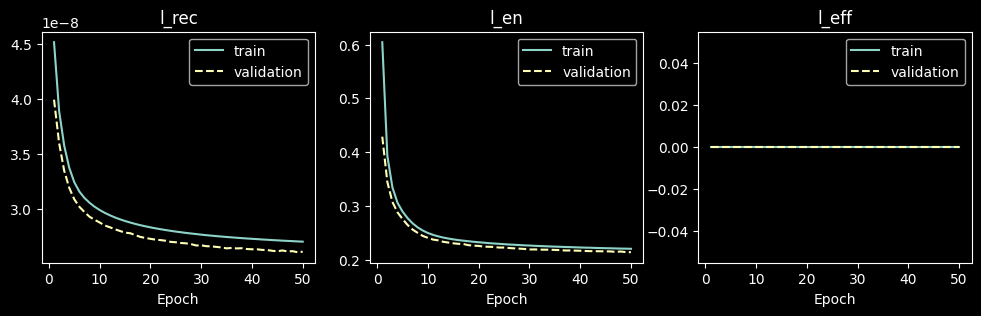

In [72]:
# Кривые обучения
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for ax, key in zip(axs, losses_parts_names):
    ax.plot(range(1, n_epochs + 1), np.array(train_epochs_loss_parts[key]), label='train')
    ax.plot(range(1, n_epochs + 1), np.array(val_epochs_loss_parts[key]), linestyle='dashed', label='validation')

    ax.set_title(key)
    ax.set_xlabel('Epoch')
    ax.legend()

plt.show()

#### Обученные маски

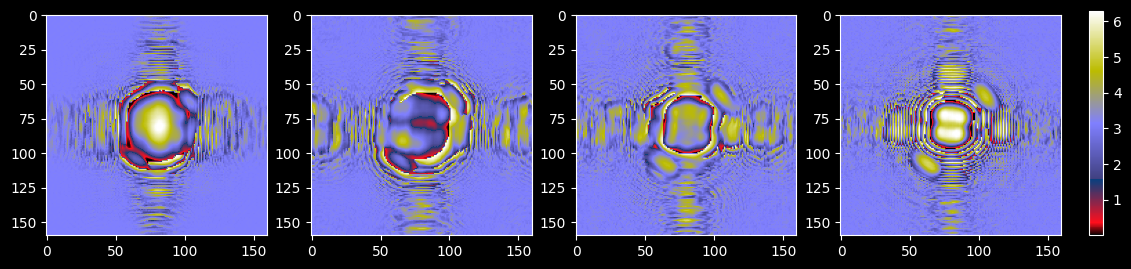

In [ ]:
n_cols = NUM_ENCODER_LAYERS  # количество столбцов для визуализации маски объекта DiffractiveLayer
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3 + 2, n_rows * 3.2))
ind_diff_layer = 0

net_type = 'encoder'
cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

net_to_plot = loaded_autoencoder.encoder if net_type == 'encoder' else loaded_autoencoder.decoder

for ind_layer, layer in enumerate(net_to_plot):
    if isinstance(layer, elements.DiffractiveLayer) or isinstance(layer, elements.SpatialLightModulator):
        # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        # ax_this.set_title(titles[ind_module])

        trained_mask = layer.mask.detach()

        phase_mask_this = ax_this.imshow(
            trained_mask, cmap=cmap,
            # vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

        if APERTURES:
            x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
            y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
            ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.01, 0.7])
plt.colorbar(phase_mask_this, cax=cbar_ax)

plt.show()

## 4.4. Пример кодирования/декодирования

### 4.4.1.Выбор образца для кодирования/декодирования

In [74]:
n_test_examples = 5

random.seed(78)
test_examples_ids = random.sample(range(len(mnist_wf_test_ds)), n_test_examples)

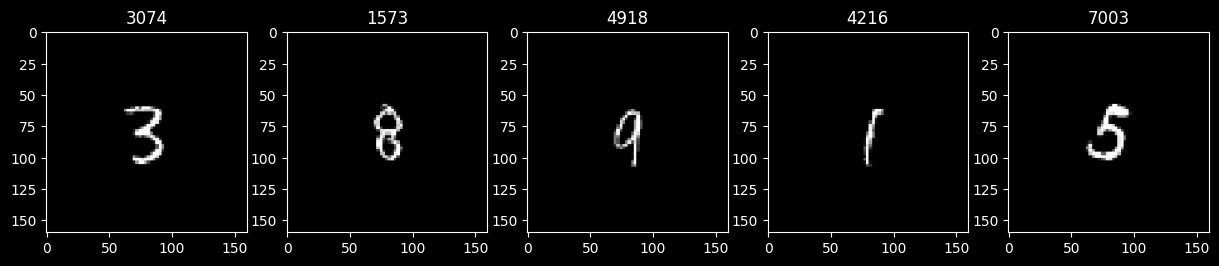

In [75]:
fig, axs = plt.subplots(1, n_test_examples, figsize=(n_test_examples * 3, 3))
cmap = 'grey'

for ax, ind_test in zip(axs, test_examples_ids):
    test_wavefront, test_target = mnist_wf_test_ds[ind_test]

    ax.set_title(f'{ind_test}')
    ax.imshow(test_wavefront.intensity, cmap=cmap)

    # ax.set_xticks([])
    # ax.set_yticks([])

plt.show()

### 4.4.2. Кодирование и декодирование примеров

#### Функции кодирования и декодирования

In [ ]:
def encode_and_decode(autoencoder, input_wf, use_encoder_aperture=False):
    # if use_encoder_aperture is True - apply strickt square aperture to encoded image
    # aperture is defined as REGION_MASK, that was used in loss!

    with torch.no_grad():
        # ENCODE
        encoded_image = autoencoder.encode(input_wf)
        if not PRESERVE_PHASE:
            encoded_image = encoded_image.abs() + 0j  # reset phases before decoding!
        if use_encoder_aperture:
            encoded_image = encoded_image * REGION_MASK  # apply aperture for encoded image

        # DECODE
        decoded_image = autoencoder.decode(encoded_image)
        if not PRESERVE_PHASE:
            decoded_image = decoded_image.abs() + 0j  # reset phases before decoding!

    return encoded_image, decoded_image

#### Отоброзить примеры

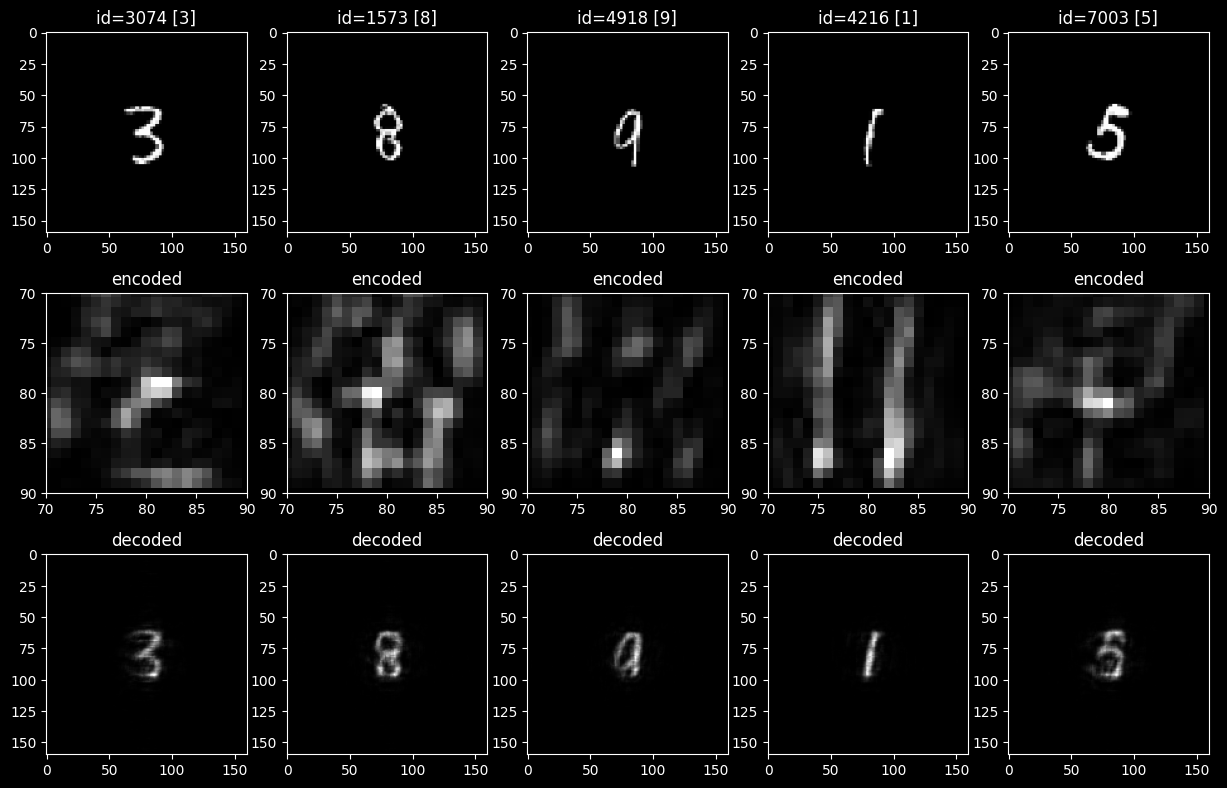

In [ ]:
n_lines = 3  # image / encoded / decoded

fig, axs = plt.subplots(n_lines, n_test_examples, figsize=(n_test_examples * 3, n_lines * 3.2))

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
use_encoder_aperture = True

max_amp = 1  # upper limits for colorplots
max_phase = 2 * torch.pi

for ind_ex, ind_test in enumerate(test_examples_ids):
    ax_image, ax_encoded, ax_decoded = axs[0][ind_ex], axs[1][ind_ex], axs[2][ind_ex]

    test_wavefront, test_target = mnist_wf_test_ds[ind_test]

    ax_image.set_title(f'id={ind_test} [{test_target}]')
    if to_plot == 'amp':
        ax_image.imshow(
            test_wavefront.intensity, cmap=cmap,
            # vmin=0, vmax=max_amp
        )
    if to_plot == 'phase':
        ax_image.imshow(
            test_wavefront.phase, cmap=cmap,
            # vmin=0, vmax=max_phase
        )

    encoded_this, decoded_this = encode_and_decode(
        loaded_autoencoder, test_wavefront, use_encoder_aperture
    )

    ax_encoded.set_title('encoded')
    if to_plot == 'amp':
        ax_encoded.imshow(
            encoded_this.intensity, cmap=cmap,
            # vmin=0, vmax=max_amp
        )
    if to_plot == 'phase':
        ax_encoded.imshow(
            encoded_this.phase, cmap=cmap,
            # vmin=0, vmax=max_phase
        )
    if use_encoder_aperture:  # select only a part within apertures!
        x_frame = (x_layer_nodes - REGION_MASK_SIZE[1]) / 2
        y_frame = (y_layer_nodes - REGION_MASK_SIZE[0]) / 2
        ax_encoded.set_xlim([x_frame, x_layer_nodes - x_frame])
        ax_encoded.set_ylim([y_layer_nodes - y_frame, y_frame])

    ax_decoded.set_title('decoded')
    if to_plot == 'amp':
        ax_decoded.imshow(
            decoded_this.intensity, cmap=cmap,
            # vmin=0, vmax=max_amp
        )
    if to_plot == 'phase':
        ax_decoded.imshow(
            decoded_this.phase, cmap=cmap,
            # vmin=0, vmax=max_phase
        )

plt.show()

#### Эксперимент декодирования суммы закодированных изображений

In [78]:
ind_test_1 = 4216
ind_test_2 = 3074

In [79]:
wf_test_1, label_test_1 = mnist_wf_test_ds[ind_test_1]
wf_test_2, label_test_2 = mnist_wf_test_ds[ind_test_2]

wf_sum = wf_test_1 + wf_test_2

In [ ]:
with torch.no_grad():
    encoded_test_1 = loaded_autoencoder.encode(wf_test_1) * REGION_MASK
    encoded_test_2 = loaded_autoencoder.encode(wf_test_2) * REGION_MASK

    if not PRESERVE_PHASE:
        encoded_test_1 = encoded_test_1.abs() + 0j
        encoded_test_2 = encoded_test_2.abs() + 0j

    encoded_sum = encoded_test_1 + encoded_test_2
    decoded_sum = loaded_autoencoder.decode(encoded_sum)
    if not PRESERVE_PHASE:
        decoded_sum = decoded_sum.abs() + 0j

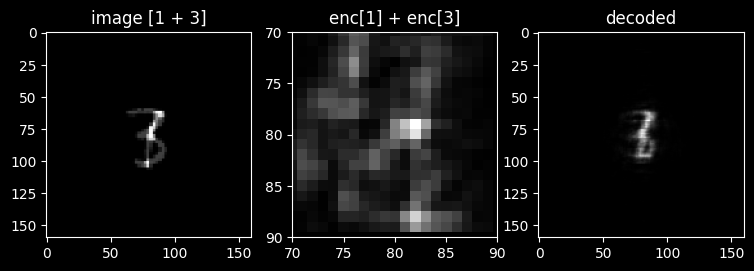

In [ ]:
n_cols = 3
n_rows = 1

to_plot = 'amp'
cmap = 'grey'


fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
titles = [f'image [{label_test_1} + {label_test_2}]', f'enc[{label_test_1}] + enc[{label_test_2}]', 'decoded']

for ind_wf, wavefront in enumerate([wf_sum, encoded_sum, decoded_sum]):
    ax_this = axs[ind_wf % n_cols]


    if ind_wf % n_cols == 1:
        x_frame = (x_layer_nodes - REGION_MASK_SIZE[1]) / 2
        y_frame = (y_layer_nodes - REGION_MASK_SIZE[0]) / 2
        ax_this.set_xlim([x_frame, x_layer_nodes - x_frame])
        ax_this.set_ylim([y_layer_nodes - y_frame, y_frame])

    ax_this.set_title(titles[ind_wf])

    if to_plot == 'amp':
        ax_this.imshow(
            wavefront.intensity.detach().numpy(), cmap=cmap,
            # vmin=0, vmax=max_intensity
        )
    if to_plot == 'phase':
        ax_this.imshow(
            wavefront.phase.detach().numpy(), cmap=cmap,
            # vmin=0, vmax=max_intensity
        )

plt.show()